In [36]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

Загружаем данные из ClickHouse

In [37]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [38]:
q = '''
    SELECT 
        number_order,
        coalesce(date_order, 'NA') as date_order,
        coalesce(planned_data_order, 'NA') as planned_date_order,
        coalesce(result_data_order, 'NA') as result_date_order,
        carrier_name,
        warehouse_cluster,
        customer_cluster,
        timeslot_number,
        order_status,
        delivery_type 
        FROM {db}.logistics_online
'''

In [39]:
logistics = ph.read_clickhouse(query=q, connection = connection_default)

In [40]:
q_1 = '''
    SELECT * 
        FROM {db}.product_online
'''

In [41]:
products = ph.read_clickhouse(query=q_1, connection = connection_default)

In [42]:
logistics.head()

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type
0,313655114,2021-5-01,2021-14-01,2021-11-01,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз
1,315229153,2021-3-01,2021-11-01,2021-8-01,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер
2,3114106095,2021-8-01,2021-16-01,2021-14-01,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер
3,31145541407,2021-12-01,2021-20-01,2021-15-01,3PL 1,Кластер Москва,Кластер Санкт-Петербург,1,Доставлен,Самовывоз
4,325050136,2021-16-01,2021-26-01,2021-25-01,3PL 1,Кластер Санкт-Петербург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз


In [43]:
q_2 = '''
    SELECT * 
        FROM {db}.returns_online
'''

In [44]:
returns = ph.read_clickhouse(query=q_2, connection = connection_default)

In [45]:
returns.head(3)

,number_order,product_ID,amount_return,return_date
0,3031410942,983588011,1,1970-01-01
1,31014374140,983586554,1,2021-07-01
2,3147145173,983589156,1,2021-11-01


In [46]:
logistics.shape

(6597, 10)

In [47]:
products.head()

,number_order,product_ID,product_price,amount
0,313655114,983587801,5512.44,1
1,313655114,983587158,4070.35,2
2,313655114,983582669,3591.97,1
3,315229153,983589424,4433.23,3
4,315229153,983587827,2862.50,2


# Предобработка и очистка данных

###### Проверим основные правила, которые должны соблюдаться в данных:
Для данных о логистике
1. Номера заказов не должны повторяться в один и тот же временной слот.
2. У всех заказов, должен быть первый временной слот
3. Планируемая и реальная дата доставки должна быть позднее, чем дата заказа.

Для данных о покупке и возврате
4. количество возвращенных вещей не должно превышать количество купленных
5. Дата возврата должна быть позже даты получения товара




### Предобработка и очиста данных логистики

#### 1 Посмотрим есть ли заказы без первого таймслота

Для этого сгруппируем данные по номеру заказа (number_order), далее для каждого номера заказа находим минимальное значение timeslot_number. Если минимальное значение timeslot_number больше одного, значит для этого заказа в данных не записан первый временной слот.

In [48]:
orders_without_first_timeslot = logistics.groupby('number_order', as_index=False) \
    .agg({'timeslot_number':'min'}) \
    .rename(columns={'timeslot_number':'min'}) \
    .query('min > 1').number_order.values

logistics[logistics.number_order.isin(orders_without_first_timeslot)]

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type
2060,33196141469,NA,2021-23-02,2021-24-02,3PL 2,Кластер Санкт-Петербург,Кластер Краснодар,2,Доставлен,Самовывоз
2099,3039114625,NA,2021-5-01,2020-31-012,3PL 2,Кластер Москва,Кластер Екатеринбург,2,Доставлен,Самовывоз
3093,304073092,NA,2021-5-01,2021-8-01,3PL 2,Кластер Краснодар,Кластер Калининград,2,Доставлен,Самовывоз
3290,300232595,NA,2021-5-01,2020-31-012,3PL 2,Кластер Москва,Кластер Новосибирск,2,Доставлен,Самовывоз
5138,3399142241,NA,2021-22-03,NA,3PL 2,Кластер Екатеринбург,Кластер Московская область,2,На пути к клиенту,Самовывоз
5279,21414577700,NA,2021-31-01,2021-1-02,Самодоставка,Кластер Екатеринбург,Кластер Москва,2,Доставлен,Курьер
6180,302073096,NA,2021-5-01,2021-5-01,3PL 2,Кластер Екатеринбург,Кластер Московская область,2,Доставлен,Самовывоз
6359,302459167,NA,2021-5-01,2021-5-01,3PL 2,Кластер Новосибирск,Кластер Центр,2,Доставлен,Самовывоз


Для заказов с пропущенным первым временным слотом мы не сможем расчитать большинство метрик из-за того что время заказа записывается именно в первом временном слоте. Поэтому мы удалим заказы без первого временного слота из дальнейшего анализа.

In [49]:
logistics.drop(    
    logistics[logistics.number_order.isin(orders_without_first_timeslot)].index,
    inplace=True
)

Так же проверяем наличие явныз дубликатов, и удаляем их

In [50]:
logistics.duplicated().sum()

1

In [51]:
logistics.drop_duplicates(inplace=True)

Далее находим заказы, в которых дублирутся номера заказаов в однм и том же временном слоте. Для этого группируем данные по номеру заказа и считаем количество строк. Ниже представлен код, для поиска повторов в первом тайм слоте. 

In [52]:
duplicqted_orders_id = logistics.query('timeslot_number == 1').number_order.value_counts().reset_index() \
    .rename(columns=({'index':'number_order', 'number_order':'count'})) \
    .query('count > 1').number_order.tolist()

logistics[logistics.number_order.isin(duplicqted_orders_id)]

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type
12,336693909,2021-9-02,2021-16-02,2021-17-02,3PL 3,Кластер Московская область,Кластер Екатеринбург,1,Доставлен,Самовывоз
13,336693909,2021-11-02,2021-16-02,2021-17-02,3PL 3,Кластер Московская область,Кластер Екатеринбург,1,Доставлен,Самовывоз
449,357469624,2021-4-03,2021-12-03,NA,3PL 3,Кластер Москва,Кластер Краснодар,1,Отменен,Курьер
450,357469624,2021-5-03,2021-12-03,NA,3PL 3,Кластер Москва,Кластер Краснодар,1,Отменен,Курьер
6426,333776216,2021-5-02,2021-11-02,2021-13-02,3PL 1,Кластер Екатеринбург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз
6427,333776216,2021-6-02,2021-11-02,2021-13-02,3PL 1,Кластер Екатеринбург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз
6428,333776216,NA,2021-12-02,2021-13-02,3PL 1,Кластер Екатеринбург,Кластер Санкт-Петербург,2,Доставлен,Самовывоз


Во всех этих заказах дата доставки была позже запланированной. Одако не был предложен новый временной слот с более поздним планируемым времененм даставки. 
Вероятно, ошибка возникла из-за того, что вместо записи заказа с новым временным слотом, дублировалась исходная запись заказа.

Так как таких заказов было не много, поэтому мы удалим их из анализа.

In [53]:
logistics.drop(
    logistics[logistics.number_order.isin(duplicqted_orders_id)].index,
    inplace=True
)

В дргих таймслотах повторов не было

### Далее подготовим данные о логистике к анализу

Сейчас дата заказа указана только в первом таймслоте. Добавим дату заказа для дургих таймслотов. Это потребудется для расчета метрики OnTime  сразбивкой по тайслотам.

In [54]:
try:
    for index in logistics.query('date_order == "NA"').index:
        n_order = logistics.loc[index,'number_order'].item()
        logistics.loc[index,'date_order'] = logistics.query('number_order == @n_order & timeslot_number ==1').date_order.item()
except:
    print(index)

Переведем дату из формата string в формат datetime, и сохраним значения, которые будут конвертироваться с ошибкой:

In [55]:
#создаем пустой лист
dates_with_errors = []

for row in logistics['date_order']:
    try:
        pd.to_datetime(row, format='%Y-%d-%m')
    except:
        #записываем значения, которые выдают ошибку при форматировании в лист
        dates_with_errors.append(row)

In [56]:
dates_with_errors

['2020-28-012',
 '2020-27-012',
 '2020-30-012',
 '2020-31-012',
 '2020-25-012',
 '2020-28-012',
 '2020-30-012',
 '2020-29-012',
 '2020-26-012',
 '2020-28-012',
 '2020-25-012',
 '2020-24-012',
 '2020-21-012',
 '2020-30-012',
 '2020-31-012',
 '2020-30-012',
 '2020-27-012',
 '2020-24-012',
 '2020-24-012',
 '2020-30-012',
 '2020-31-012',
 '2020-25-012',
 '2020-31-012',
 '2020-22-012',
 '2020-26-012',
 '2020-29-012',
 '2020-31-012',
 '2020-31-012',
 '2020-31-012',
 '2020-23-012',
 '2020-28-012',
 '2020-28-012',
 '2020-31-012',
 '2021-01-002']

В ряде случаев месяц записывался в в иде трех значений, например '012' или '002'. Чтобы эти значения считывались верно, нам нужно убрать ноль, который стоит в самом начале так чтобы из '002' получить '02':

In [57]:
#если значение дня, месяца или года начинается с нуля, то удаляем этот ноль
logistics['date_order'] = logistics['date_order'].apply(lambda x: x.replace('-0','-')) 

Далее переводим столбцы с даной в формате datetime. В данных дата указана в формате ГОД-ДЕНЬ-МЕСЯЦ. Это необычный формат для записи даты, который потенциально может приводить к ошибкам при конвертировании из формата string в формат datetime.

In [58]:
logistics['date_order'] = pd.to_datetime(logistics['date_order'], format ='%Y-%d-%m')
logistics['planned_date_order'] = pd.to_datetime(logistics['planned_date_order'], format ='%Y-%d-%m')
logistics['result_date_order'] = pd.to_datetime(logistics['result_date_order'], format ='%Y-%d-%m', errors = 'coerce')

### Проверим как распределяется количество заказов во времени

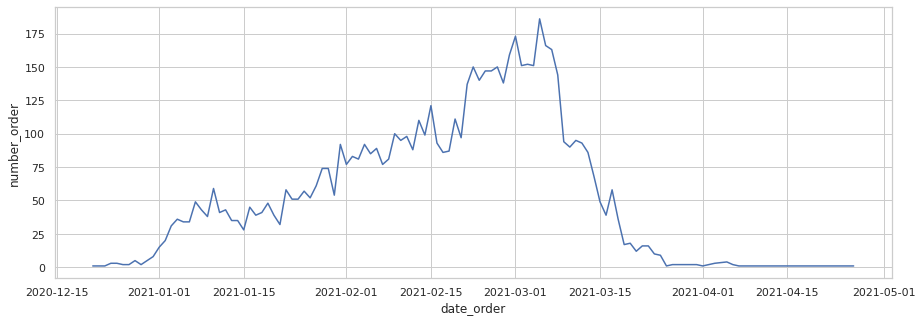

In [59]:
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("whitegrid")
sns.lineplot(data=logistics.groupby('date_order', as_index=False).number_order.count(), x='date_order', y='number_order')

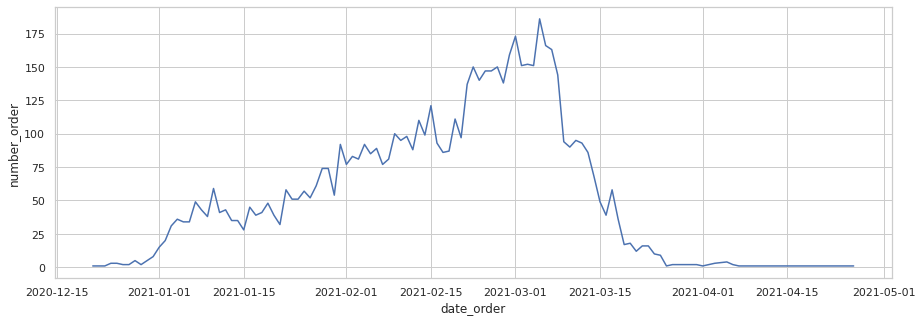

In [60]:
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("whitegrid")
sns.lineplot(data=logistics.groupby('date_order', as_index=False).number_order.count(), x='date_order', y='number_order')

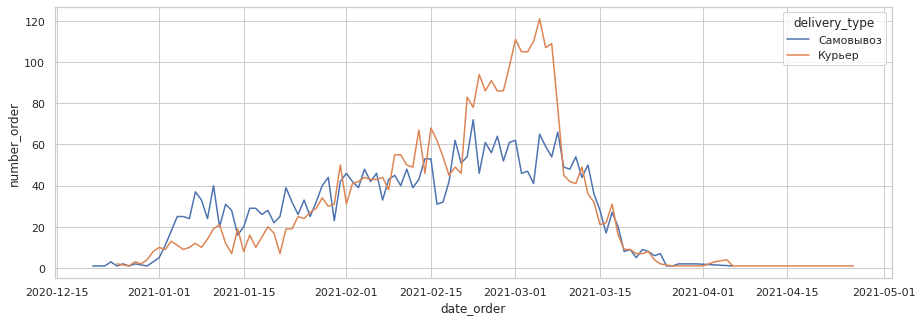

In [61]:
sns.lineplot(data=logistics.groupby(['date_order','delivery_type'], as_index=False).number_order.count(), 
                 x='date_order', y='number_order', hue ='delivery_type')

In [62]:
logistics['date_error'] = (logistics['date_order'] > logistics['result_date_order'])

Пометим все заказы, где дата заказа была позде даты получения

In [63]:
ozon_data = logistics.copy(deep=True)

In [64]:
ozon_data['errors'] = (ozon_data['date_order'] > ozon_data['result_date_order'])

In [65]:
ozon_data

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,date_error,errors
0,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,False,False
1,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,False
2,3114106095,2021-01-08,2021-01-16,2021-01-14,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,False
3,31145541407,2021-01-12,2021-01-20,2021-01-15,3PL 1,Кластер Москва,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,False,False
4,325050136,2021-01-16,2021-01-26,2021-01-25,3PL 1,Кластер Санкт-Петербург,Кластер Санкт-Петербург,1,Доставлен,Самовывоз,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
6592,361544120,2021-03-14,2021-03-19,2021-03-15,3PL 2,Кластер Северо-Запад,Кластер Краснодар,1,Доставлен,Самовывоз,False,False
6593,362569711,2021-03-18,2021-03-22,NaT,3PL 2,Кластер Северо-Запад,Кластер Екатеринбург,1,На пути к клиенту,Самовывоз,False,False
6594,3645314759,2021-03-14,2021-03-23,NaT,3PL 2,Кластер Казань,Кластер Краснодар,1,На пути к клиенту,Самовывоз,False,False
6595,3649144391,2021-03-24,2021-03-28,NaT,Самодоставка,Кластер Екатеринбург,Кластер Екатеринбург,1,Ожидает сборки,Курьер,False,False


In [66]:
ozon_data['C2D'] = ozon_data['result_date_order'] - ozon_data['date_order']
ozon_data['C2D'] = ozon_data['C2D'].dt.days

In [67]:
sum(ozon_data['date_order'] > ozon_data['result_date_order'])

925

In [68]:
sum(ozon_data['date_order'] > ozon_data['planned_date_order'])

0

In [69]:
len(ozon_data.number_order.unique())

5965

In [70]:
ozon_data.groupby(['date_order'], as_index=False).errors.mean()

,date_order,errors
0,2020-12-21,0.0
1,2020-12-22,0.0
2,2020-12-23,0.0
3,2020-12-24,0.0
4,2020-12-25,0.0
...,...,...
108,2021-04-20,0.0
109,2021-04-21,0.0
110,2021-04-22,0.0
111,2021-04-25,0.0


In [71]:
#ozon_data['date_order'] = ozon_data['date_order'].dt.to_period("W").dt.start_time

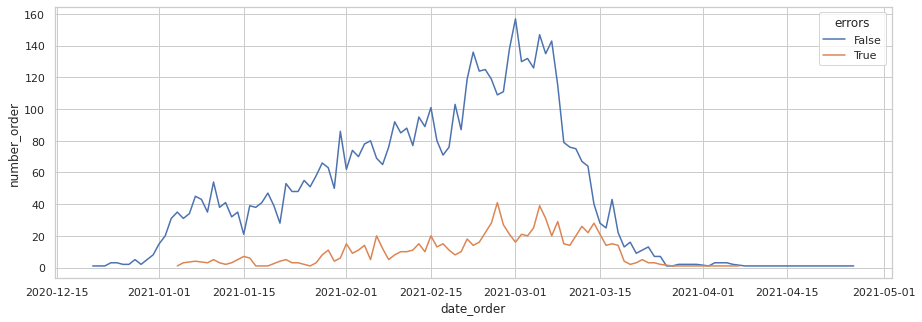

In [72]:
sns.lineplot(data = ozon_data.groupby(['date_order','errors'], as_index=False).number_order.count()
    .sort_values('errors', ascending=False), x='date_order', y='number_order', hue = 'errors')

In [73]:
ozon_data.groupby(['customer_cluster','warehouse_cluster', 'carrier_name'], as_index=False).errors.mean()

,customer_cluster,warehouse_cluster,carrier_name,errors
0,Кластер Екатеринбург,Кластер Екатеринбург,3PL 1,0.023810
1,Кластер Екатеринбург,Кластер Екатеринбург,3PL 2,0.208333
2,Кластер Екатеринбург,Кластер Екатеринбург,3PL 3,0.000000
3,Кластер Екатеринбург,Кластер Екатеринбург,3PL 4,0.333333
4,Кластер Екатеринбург,Кластер Екатеринбург,Самодоставка,0.741883
...,...,...,...,...
362,Кластер Якутия,Кластер Московская область,3PL 3,0.000000
363,Кластер Якутия,Кластер Новосибирск,3PL 2,0.500000
364,Кластер Якутия,Кластер Санкт-Петербург,3PL 1,0.000000
365,Кластер Якутия,Кластер Санкт-Петербург,3PL 2,0.000000


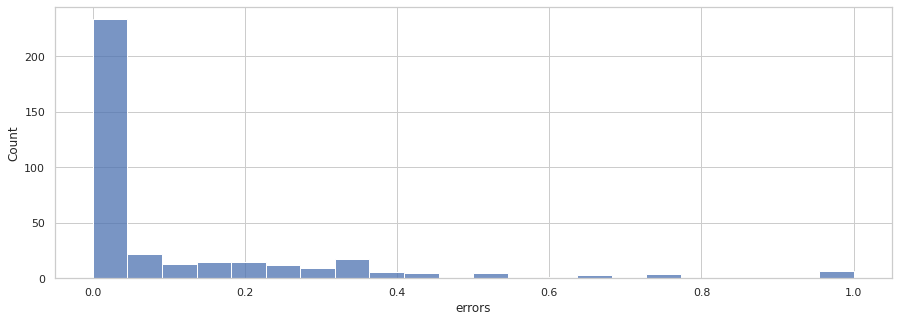

In [74]:
sns.histplot(ozon_data.groupby(['customer_cluster','warehouse_cluster', 'carrier_name'], as_index=False).errors.mean() \
    .sort_values('errors', ascending=False).errors)

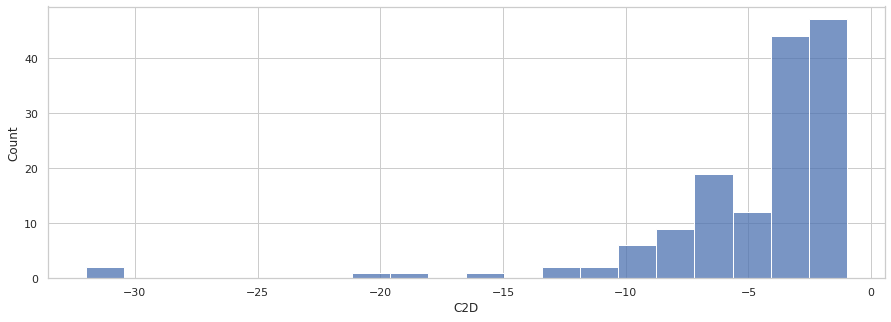

In [75]:
sns.histplot(ozon_data.query('C2D < 0')
             .groupby(['customer_cluster','warehouse_cluster', 'carrier_name'], as_index=False).C2D.mean() \
    .sort_values('C2D', ascending=False).C2D)

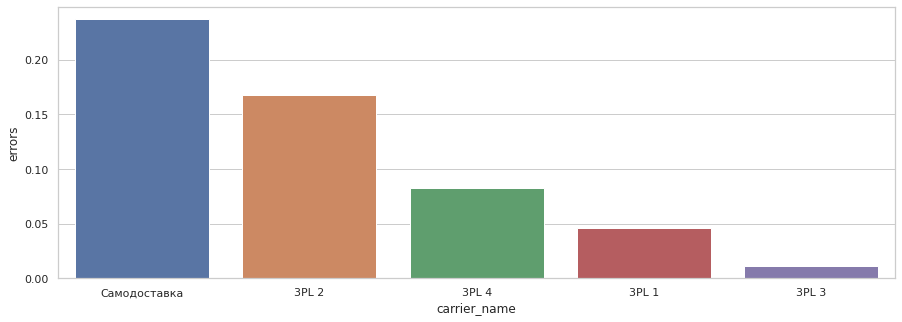

In [76]:
sns.barplot(data=ozon_data.groupby(['carrier_name'], as_index=False).errors.mean() \
    .sort_values('errors', ascending=False), x='carrier_name', y='errors')

In [77]:
C2D_by_cluster = ozon_data \
    .groupby(['warehouse_cluster', 'customer_cluster'], as_index=False).errors.mean() \
    .sort_values('errors', ascending=True)
C2D_by_cluster['errors'] = C2D_by_cluster.errors.round(1)

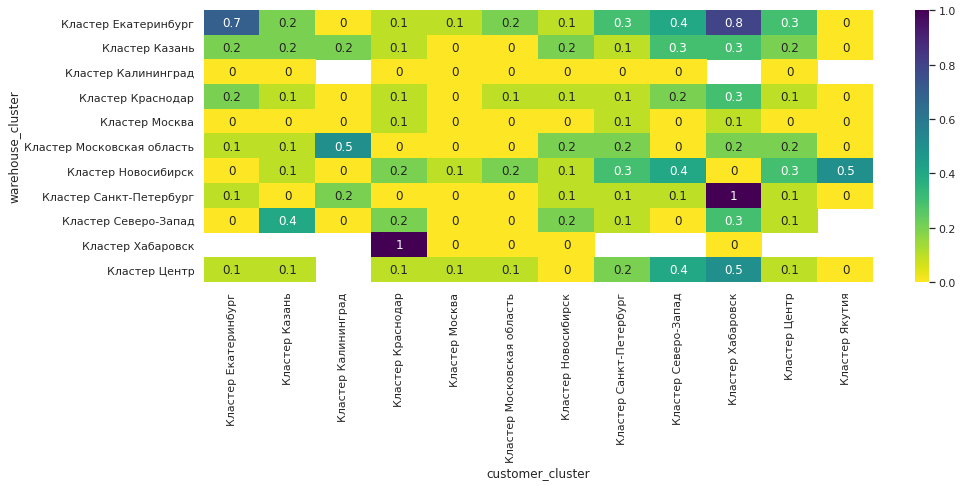

In [78]:

sns.heatmap( 
            C2D_by_cluster.pivot(index='warehouse_cluster', 
                                  columns = 'customer_cluster', 
                                  values = 'errors'), 
            annot=True,
            cmap="viridis_r")

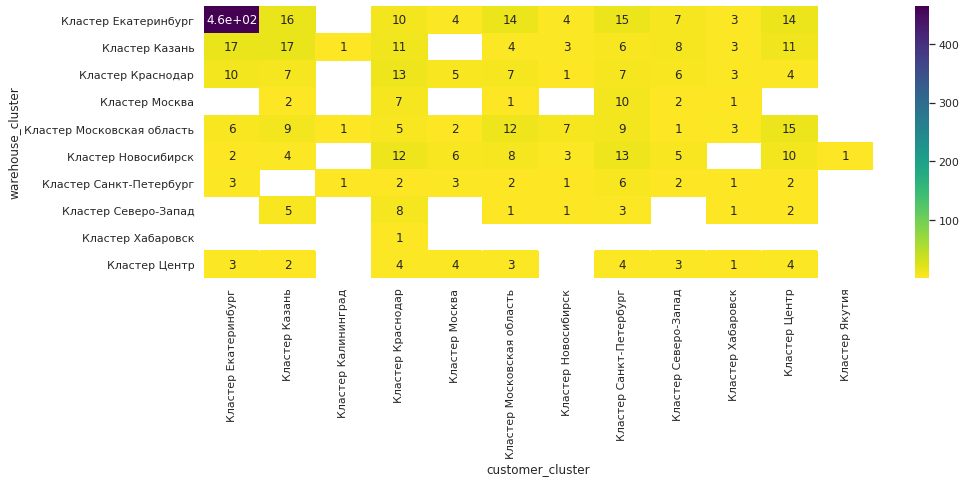

In [79]:
C2D_by_cluster = ozon_data.query('errors == True') \
    .groupby(['warehouse_cluster', 'customer_cluster'], as_index=False).C2D.count() \
    .sort_values('C2D', ascending=True)
sns.heatmap( 
            C2D_by_cluster.pivot(index='warehouse_cluster', 
                                  columns = 'customer_cluster', 
                                  values = 'C2D'), 
            annot=True,
            cmap="viridis_r")


In [80]:
test = products.merge(returns, on = ['number_order','product_ID'], how = 'left')
test['amount_return'] = test.amount_return.fillna(0)

test = test.merge(logistics.query('timeslot_number == 1'), on ='number_order', how = 'left')
test['return_date'] = pd.to_datetime(test['return_date'], errors = 'coerce')

In [81]:
test.head()

,number_order,product_ID,product_price,amount,amount_return,return_date,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,date_error
0,313655114,983587801,5512.44,1,0.0,NaT,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1.0,Доставлен,Самовывоз,False
1,313655114,983587158,4070.35,2,0.0,NaT,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1.0,Доставлен,Самовывоз,False
2,313655114,983582669,3591.97,1,0.0,NaT,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1.0,Доставлен,Самовывоз,False
3,315229153,983589424,4433.23,3,0.0,NaT,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1.0,Доставлен,Курьер,False
4,315229153,983587827,2862.50,2,0.0,NaT,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1.0,Доставлен,Курьер,False


In [82]:
test['days_to_return'] = test['result_date_order'] - test['return_date']

In [83]:
test['days_to_return'] = test['days_to_return'].dt.days

In [84]:
test['return_date_error'] = test['days_to_return'].apply(lambda x: 1 if x > 100 or x < 0 else 0)

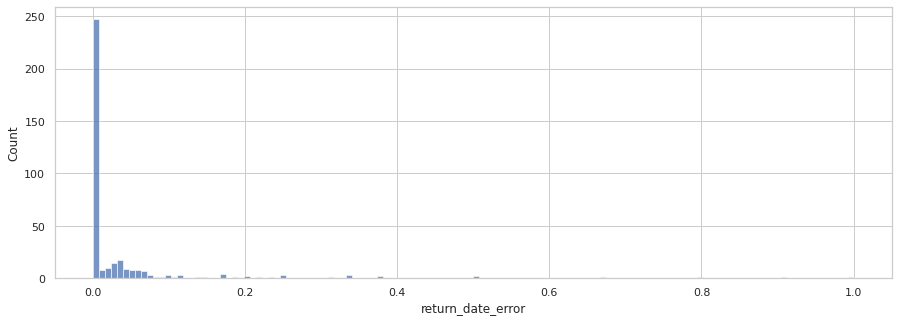

In [85]:
sns.histplot(test.groupby(['customer_cluster','warehouse_cluster', 'carrier_name'], as_index=False).return_date_error.mean() \
    .sort_values('return_date_error', ascending=False).return_date_error)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


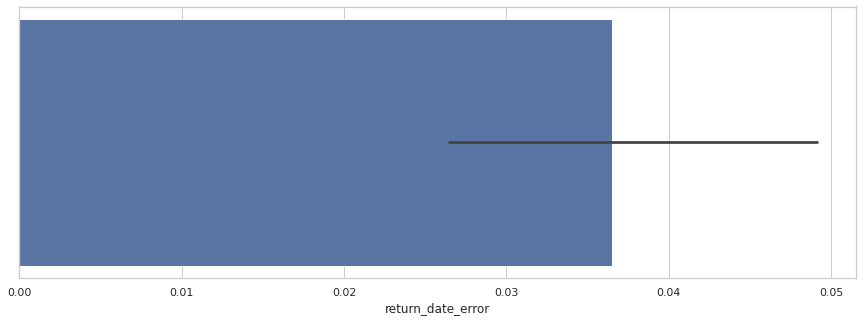

In [86]:
sns.barplot(
    
    test.groupby(['customer_cluster','warehouse_cluster', 'carrier_name'], as_index=False).return_date_error.mean() \
    .sort_values('return_date_error', ascending=False).return_date_error
)

In [87]:
test_heatmap = test \
    .groupby(['warehouse_cluster', 'customer_cluster'], as_index=False).return_date_error.mean() \
    .sort_values('return_date_error', ascending=True)

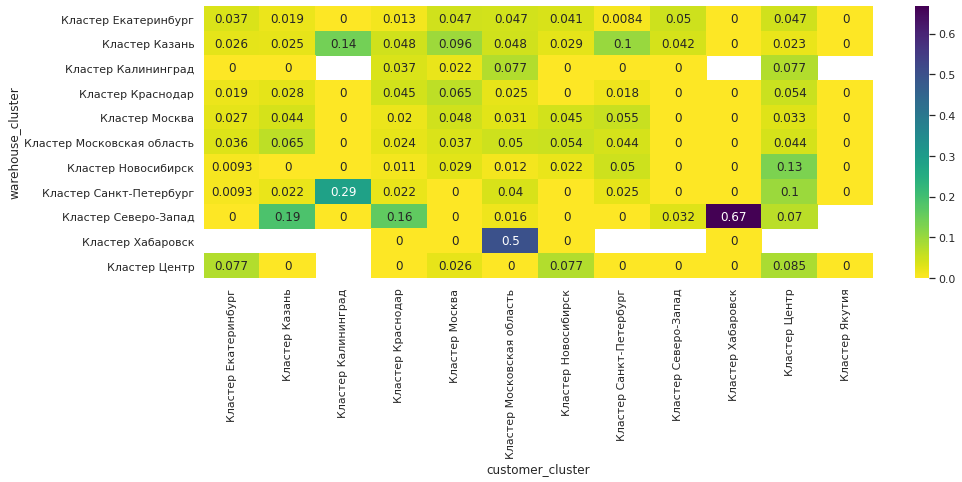

In [88]:
sns.heatmap( 
            test_heatmap.pivot(index='warehouse_cluster', 
                                  columns = 'customer_cluster', 
                                  values = 'return_date_error'), 
            annot=True,
            cmap="viridis_r")

In [151]:
returns['return_date'] = pd.to_datetime(returns['return_date'], format ='%Y-%d-%m', errors = 'coerce')

## 1. Посчитать OnTime - Метрика своевременности доставки. (Доставили в плановую дату доставки или нет), в %

 - Необходимо видеть изменение метрики по дням;

 - Необходимы разрезы по перевозчикам, по типу доставки, по кластерам склада, по таймслотам;

In [89]:
logistics.drop(    
    logistics[logistics['date_error']==True].index,
    inplace=True
)

In [90]:
def on_time(row):
    if row['planned_date_order'] == row['result_date_order']:
        return 1
    else:
        return 0

In [91]:
logistics['on_time'] = logistics.apply(on_time, axis=1)

In [92]:
logistics.head(3)

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,date_error,on_time
0,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,False,0
1,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,0
2,3114106095,2021-01-08,2021-01-16,2021-01-14,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,0


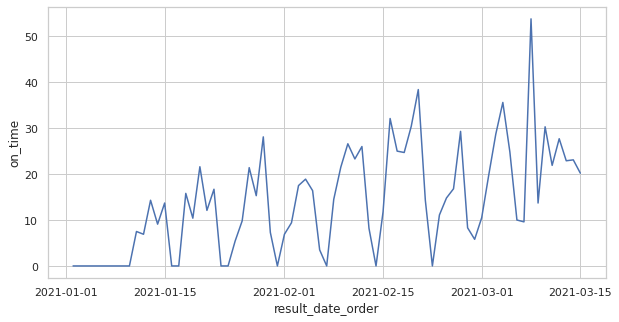

In [93]:

sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")

on_time_by_planned_date = logistics.groupby('result_date_order', as_index=False).on_time.mean()
on_time_by_planned_date['on_time'] = on_time_by_planned_date['on_time'].apply(lambda x: round(x*100,1))
sns.lineplot(data = on_time_by_planned_date, x='result_date_order', y = 'on_time')

Динамика метрики OnTime по дням показывает растущий тренд. Это может говорить о том, что алгоритмы. которые предсказывают дату доставки, становятся все лучше. Так же на графике видны резкие спады метрики до нуля на выходных. Вероятно это связано с тем, что планируемая дата доставки редко выпадает на выходные, в то время как фактическая дата доставки -   

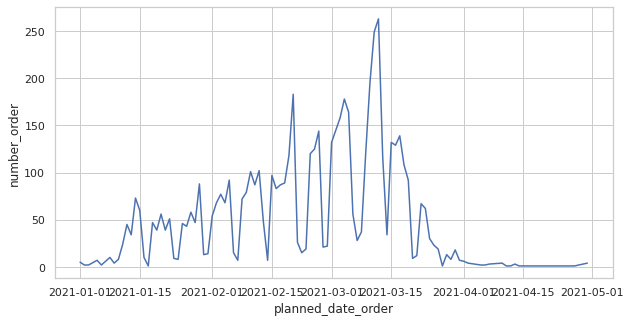

In [94]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")

on_time_by_planned_date = logistics.groupby('planned_date_order', as_index=False).number_order.count()
sns.lineplot(data = on_time_by_planned_date, x='planned_date_order', y = 'number_order')

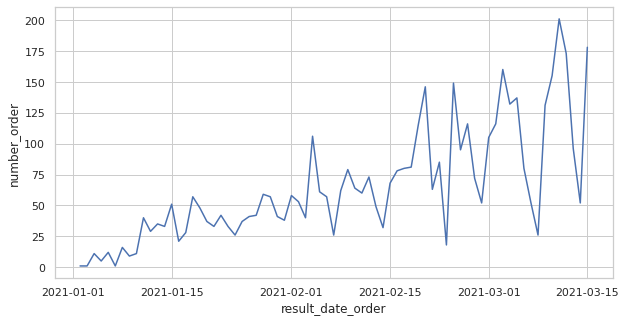

In [95]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")

on_time_by_planned_date = logistics.groupby('result_date_order', as_index=False).number_order.count()
sns.lineplot(data = on_time_by_planned_date, x='result_date_order', y = 'number_order')

In [96]:
on_time_by_carrier_name  = logistics.groupby('carrier_name', as_index=False).on_time.mean()
on_time_by_carrier_name['on_time'] = on_time_by_carrier_name['on_time'].apply(lambda x: round(x*100,1))

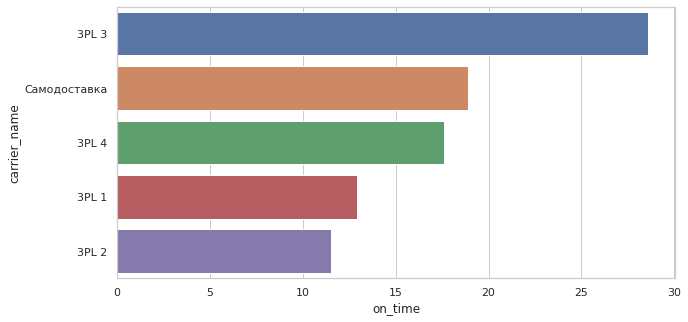

In [97]:
on_time_by_carrier_name  = logistics.groupby('carrier_name', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_carrier_name['on_time'] = on_time_by_carrier_name['on_time'].apply(lambda x: round(x*100,1))
sns.barplot(data = on_time_by_carrier_name, y='carrier_name', x = 'on_time')

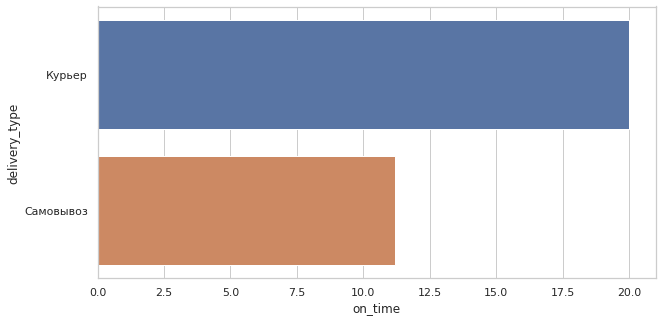

In [98]:
on_time_by_delivery_type  = logistics.groupby('delivery_type', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_delivery_type['on_time'] = on_time_by_delivery_type['on_time'].apply(lambda x: round(x*100,1))
sns.barplot(data = on_time_by_delivery_type, y='delivery_type', x = 'on_time')

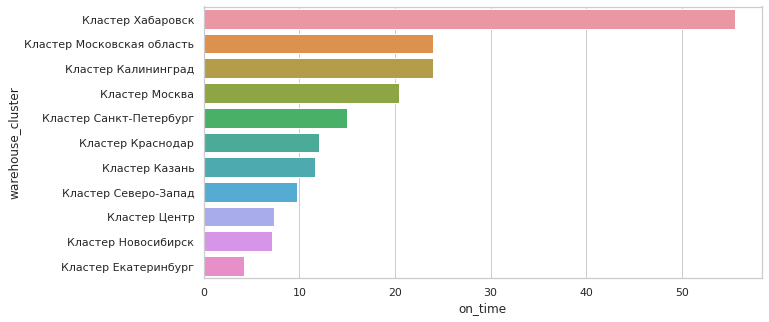

In [99]:
on_time_by_warehouse_cluster  = logistics.groupby('warehouse_cluster', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_warehouse_cluster['on_time'] = on_time_by_warehouse_cluster['on_time'].apply(lambda x: round(x*100,1))
sns.barplot(data = on_time_by_warehouse_cluster, y='warehouse_cluster', x = 'on_time')

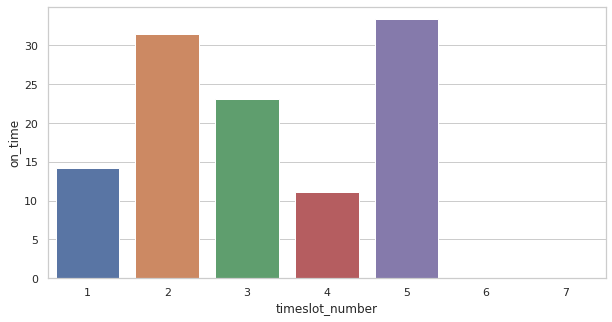

In [100]:
on_time_by_timeslot_number  = logistics.groupby('timeslot_number', as_index=False).on_time.mean().sort_values('on_time', ascending=False)
on_time_by_timeslot_number['on_time'] = on_time_by_timeslot_number['on_time'].apply(lambda x: round(x*100,1))
sns.barplot(data = on_time_by_timeslot_number, x='timeslot_number', y = 'on_time')

## 2. Посчитать PromisedClick2Delivery - метрика обещанного срока доставки (от даты заказа до первой плановой даты доставки), в сутках.

 - Необходима динамика по дням, неделям, месяцам;

 - Необходимо сравнение перевозчиков;

 - Необходимо понимание уровня метрики из кластера в кластер.

Удалим данные, которые не подойдут для расчета метрик

In [101]:
#удалим все данные о доставках кроме первого временного слота. Далее они нам не понадобятся.

logistics.drop(    
    logistics[logistics['timeslot_number'] != 1].index,
    inplace=True
)

In [102]:
# Удалим заказы , которые еще не были доставлены.
# При сравнении метрик важно, чтобы они расчитывались на схожих данных. Поэтому мы оставляем только те данные, которые подойдут
# Для расчета и PromisedClick2Delivery и Click2Delivery

logistics_without_na_dates = logistics.drop(    
    logistics[logistics.result_date_order.isna()].index
)

In [103]:
# Удалим заказы , которые еще не были доставлены.
# При сравнении метрик важно, чтобы они расчитывались на схожих данных. Поэтому мы оставляем только те данные, которые подойдут
# Для расчета и PromisedClick2Delivery и Click2Delivery
#logistics.drop(
#    logistics[logistics.result_date_order.isna()].index,
#    inplace=True
#)

In [104]:
logistics_without_na_dates['PromisedClick2Delivery'] = logistics_without_na_dates['planned_date_order'] - logistics_without_na_dates['date_order']
logistics_without_na_dates['PromisedClick2Delivery'] = logistics_without_na_dates['PromisedClick2Delivery'].dt.days

logistics_without_na_dates['Click2Delivery'] = logistics_without_na_dates['result_date_order'] - logistics_without_na_dates['date_order']
logistics_without_na_dates['Click2Delivery'] = logistics_without_na_dates['Click2Delivery'].dt.days


Проверим, как выглядит распределение ожидаемого времени доставки

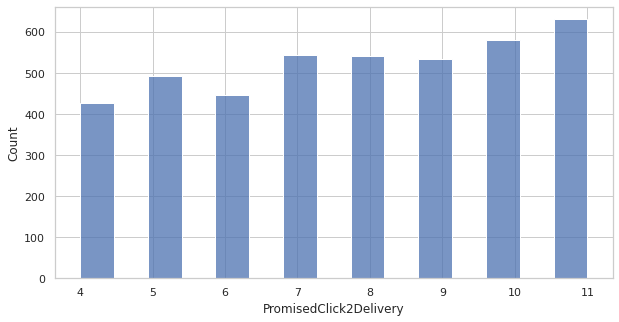

In [105]:
sns.histplot(logistics_without_na_dates['PromisedClick2Delivery'])

Время доставки имеет немного скошенное распределение, но небольшой разброс,поэтому мы будем использовать среднее значение дня расчета PromisedClick2Delivery. Основное преимущество среднего значанения - возможность наблюдать изменения в десятичных долях в метрики.

###### Динамика по дням

In [106]:
PC2D_days = logistics_without_na_dates.groupby('date_order', as_index=False).agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})
PC2D_days = PC2D_days.melt('date_order', var_name='metrics', value_name='days')


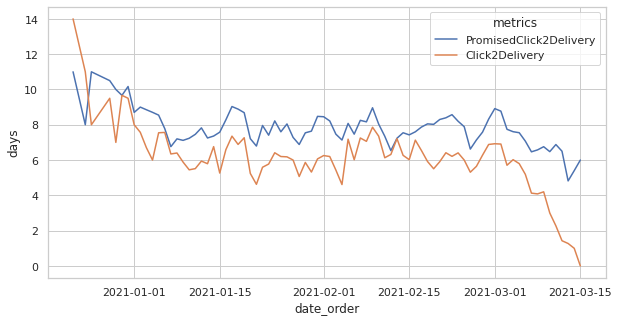

In [107]:
sns.lineplot(data=PC2D_days, x='date_order', y = 'days', hue = 'metrics')

Важно отметить, что по данному графику нельзя делать выводы, так как в некоторые дни был совершен всего один заказ, а в некоторые - больше 100.

###### Динамика по неделям


In [108]:
PC2D_weeks = logistics_without_na_dates
PC2D_weeks['date_order'] = PC2D_weeks['date_order'].dt.to_period("W").dt.start_time
PC2D_weeks = PC2D_weeks.groupby('date_order', as_index=False).agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})
PC2D_weeks = PC2D_weeks.melt('date_order', var_name='metrics', value_name='days')


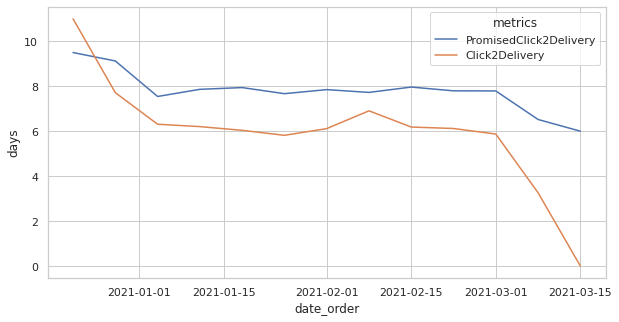

In [109]:
sns.lineplot(data=PC2D_weeks, x='date_order', y = 'days', hue = 'metrics')

###### Динамика по месяцам

In [110]:
PC2D_month = logistics_without_na_dates
PC2D_month['date_order'] = PC2D_month['date_order'].dt.to_period("M").dt.start_time
PC2D_month = PC2D_month.groupby('date_order', as_index=False).agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})
PC2D_month = PC2D_month.melt('date_order', var_name='metrics', value_name='days')

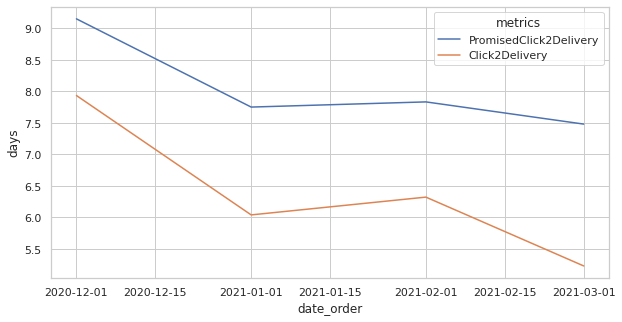

In [111]:
sns.lineplot(data=PC2D_month, x='date_order', y = 'days', hue = 'metrics')

###### сравнение перевозчиков

In [112]:

PC2D_by_carrier = logistics_without_na_dates.groupby('carrier_name', as_index=False).agg({'PromisedClick2Delivery':'mean', 'Click2Delivery':'mean'})
PC2D_by_carrier = PC2D_by_carrier.melt('carrier_name', var_name='metrics', value_name='days').sort_values('days', ascending=True)

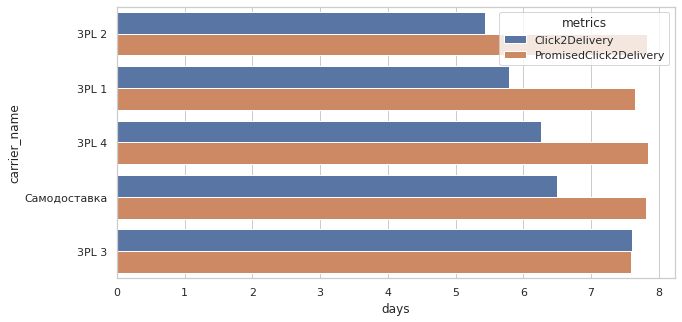

In [113]:
sns.barplot(data=PC2D_by_carrier, y='carrier_name', x = 'days', hue = 'metrics')

###### сравнение по кластерам PromisedClick2Delivery

In [114]:
PC2D_by_cluster = logistics_without_na_dates.groupby(['warehouse_cluster', 'customer_cluster'], as_index=False).PromisedClick2Delivery.mean() \
    .sort_values('PromisedClick2Delivery', ascending=True)

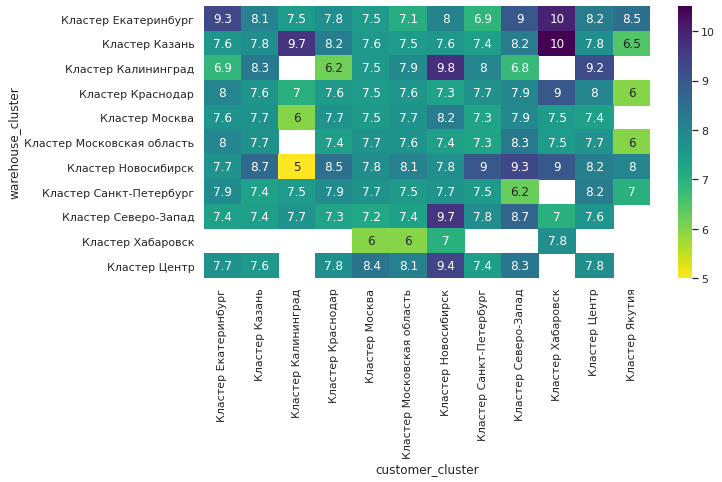

In [115]:

sns.heatmap( 
            PC2D_by_cluster.pivot(index='warehouse_cluster', 
                                  columns = 'customer_cluster', 
                                  values = 'PromisedClick2Delivery'), 
            annot=True,
            cmap="viridis_r")


###### сравнение по кластерам: разница между предсказанным и реальным временем доставки


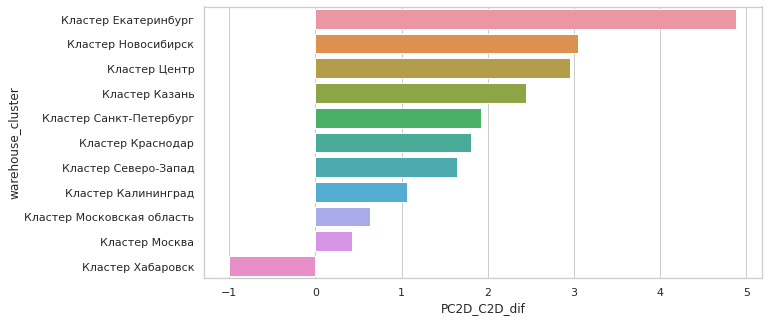

In [116]:
PC2D_C2D_dif_by_carrier = logistics_without_na_dates

PC2D_C2D_dif_by_carrier['PC2D_C2D_dif'] = PC2D_C2D_dif_by_carrier['PromisedClick2Delivery'] - PC2D_C2D_dif_by_carrier['Click2Delivery']

PC2D_C2D_dif_by_carrier = PC2D_C2D_dif_by_carrier.groupby('warehouse_cluster', as_index=False).agg({'PC2D_C2D_dif':'mean'}) \
    .sort_values('PC2D_C2D_dif', ascending=False)
#PC2D_C2D_dif_by_carrier.dropna(inplace=True)
sns.barplot(data=PC2D_C2D_dif_by_carrier, x='PC2D_C2D_dif', y = 'warehouse_cluster')

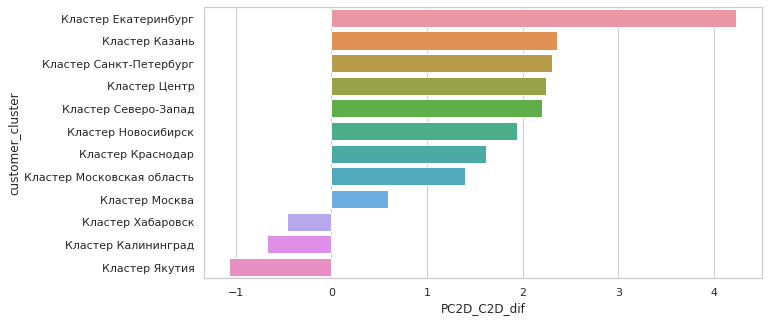

In [117]:
PC2D_C2D_dif_by_carrier = logistics_without_na_dates

PC2D_C2D_dif_by_carrier['PC2D_C2D_dif'] = PC2D_C2D_dif_by_carrier['PromisedClick2Delivery'] - PC2D_C2D_dif_by_carrier['Click2Delivery']

PC2D_C2D_dif_by_carrier = logistics_without_na_dates.groupby('customer_cluster', as_index=False).agg({'PC2D_C2D_dif':'mean'}) \
    .sort_values('PC2D_C2D_dif', ascending=False)
#PC2D_C2D_dif_by_carrier.dropna(inplace=True)
sns.barplot(data=PC2D_C2D_dif_by_carrier, x='PC2D_C2D_dif', y = 'customer_cluster')

## 4. Посчитать GMV Accepted - метрика совокупного объема продаж (считается по заказам, оформленным в указанный день), в рублях.

 - Необходимо видеть изменение метрики по дням;

 - Необходимы разрезы по перевозчикам, по типу доставки, по кластерам склада;

In [118]:
logistics_and_products_merged = logistics.merge(products, on='number_order', how='left')
#logistics
#products

In [119]:
logistics_and_products_merged.head()

,number_order,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,date_error,on_time,product_ID,product_price,amount
0,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,False,0,983587801,5512.44,1
1,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,False,0,983587158,4070.35,2
2,313655114,2021-01-05,2021-01-14,2021-01-11,3PL 1,Кластер Москва,Кластер Краснодар,1,Доставлен,Самовывоз,False,0,983582669,3591.97,1
3,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,0,983589424,4433.23,3
4,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,0,983587827,2862.50,2


In [120]:
logistics_and_products_merged['gmv_accepted'] = logistics_and_products_merged['product_price'] * \
    logistics_and_products_merged['amount']

Посчитаем динамику GMV Accepted по дням

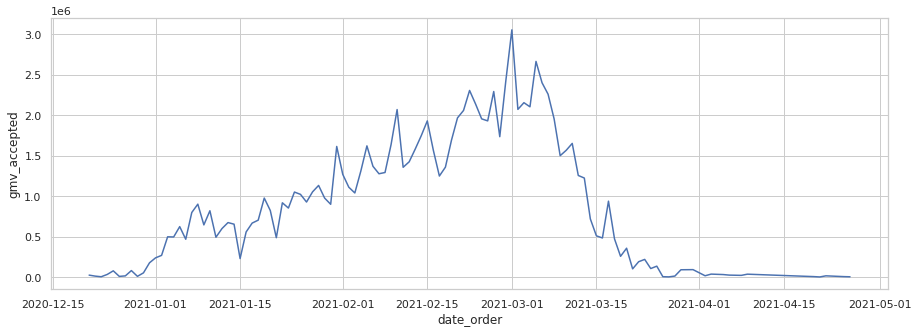

In [125]:
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("whitegrid")
sns.lineplot(
    data = logistics_and_products_merged.groupby('date_order', as_index=False).gmv_accepted.sum(),
    x='date_order', y='gmv_accepted'
)

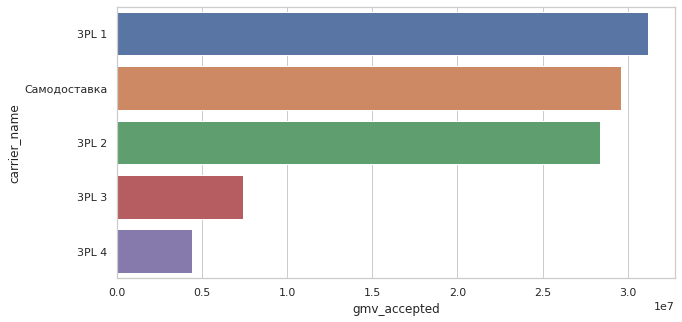

In [122]:
sns.barplot(
    data = logistics_and_products_merged.groupby('carrier_name', as_index=False).gmv_accepted.sum() \
        .sort_values('gmv_accepted', ascending=False),
    y='carrier_name', x='gmv_accepted'
)

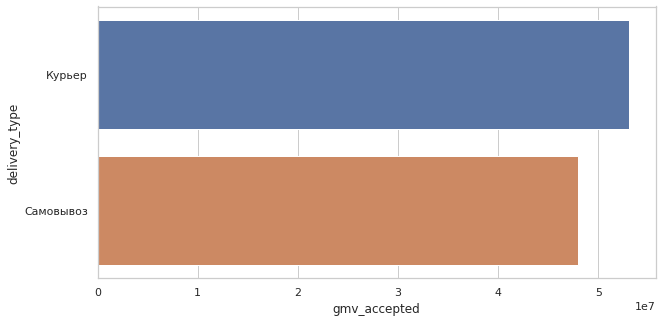

In [123]:
sns.barplot(
    data = logistics_and_products_merged.groupby('delivery_type', as_index=False).gmv_accepted.sum() \
        .sort_values('gmv_accepted', ascending=False),
    y='delivery_type', x='gmv_accepted'
)

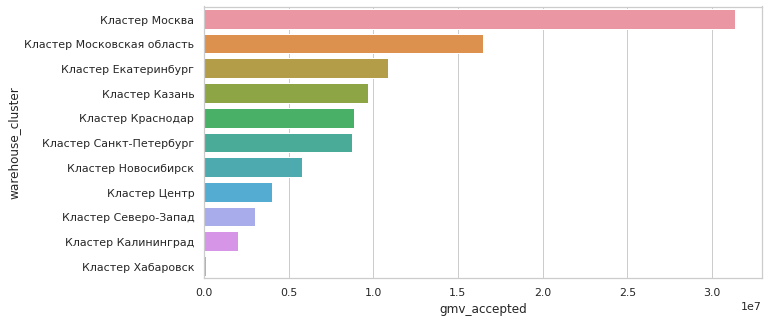

In [124]:
sns.barplot(
    data = logistics_and_products_merged.groupby('warehouse_cluster', as_index=False).gmv_accepted.sum() \
        .sort_values('gmv_accepted', ascending=False),
    y='warehouse_cluster', x='gmv_accepted'
)

## 5. Посчитать Return Rate - доля возвратов (отношение количества возвратов к заказам в этот день), в %.

 - Необходимо видеть изменение метрики по дням;

 - Необходимы разрезы по перевозчикам, по кластерам склада и клиента;

In [ ]:
logist_prod_return_merged = logistics_and_products_merged.merge(returns, left_on='date_order', 
                                                                right_on='return_date', how='inner')

In [ ]:
return_rate_daily = logist_prod_return_merged.groupby('date_order', as_index=False) \
    .agg({'amount':'sum', 'amount_return':'sum'}).sort_values('date_order')
return_rate_daily['return_rate'] = (return_rate_daily['amount_return'] / return_rate_daily['amount'])*100

In [ ]:
fig = px.bar(return_rate_daily, x='date_order', y='return_rate')
fig.show()

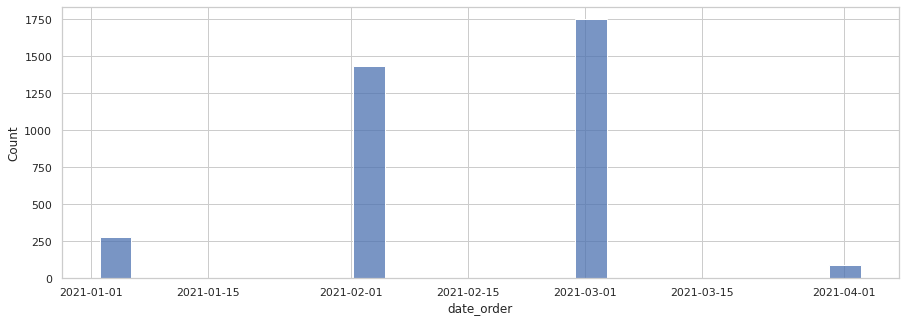

In [135]:
sns.histplot(logist_prod_return_merged.date_order)

In [136]:
logist_prod_return_merged.head()

,number_order_x,date_order,planned_date_order,result_date_order,carrier_name,warehouse_cluster,customer_cluster,timeslot_number,order_status,delivery_type,date_error,on_time,product_ID_x,product_price,amount,gmv_accepted,number_order_y,product_ID_y,amount_return,return_date
0,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,0,983589424,4433.23,3,13299.69,349649711,983586911,1,2021-01-03
1,315229153,2021-01-03,2021-01-11,2021-01-08,Самодоставка,Кластер Московская область,Кластер Московская область,1,Доставлен,Курьер,False,0,983587827,2862.50,2,5725.00,349649711,983586911,1,2021-01-03
2,31714414261,2021-01-03,2021-01-13,2021-01-14,3PL 3,Кластер Казань,Кластер Казань,1,Доставлен,Самовывоз,False,0,983583589,5676.85,3,17030.55,349649711,983586911,1,2021-01-03
3,31714414261,2021-01-03,2021-01-13,2021-01-14,3PL 3,Кластер Казань,Кластер Казань,1,Доставлен,Самовывоз,False,0,983588665,3986.37,2,7972.74,349649711,983586911,1,2021-01-03
4,31714414261,2021-01-03,2021-01-13,2021-01-14,3PL 3,Кластер Казань,Кластер Казань,1,Доставлен,Самовывоз,False,0,983581727,3386.09,1,3386.09,349649711,983586911,1,2021-01-03
